In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Tuple, List, Optional, Dict

import numpy as np
import pandas as pd
from PIL import Image


from sklearn.model_selection import train_test_split


from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt



In [2]:
from tqdm import tqdm
import random



In [3]:
df_mask = pd.read_csv('list_attr_celeba.csv')

In [12]:
df_selected= pd.read_csv('selected_arcface_mainset_1.csv')

In [14]:
df_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [16]:
print(df_selected.columns)
print(df_mask.columns)


Index(['image_id', 'label'], dtype='object')
Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [18]:
df_with_attrs = df_selected.merge(
    df_mask,
    on="image_id",
    how="inner"
)


In [20]:
df_with_attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             14000 non-null  object
 1   label                14000 non-null  int64 
 2   5_o_Clock_Shadow     14000 non-null  int64 
 3   Arched_Eyebrows      14000 non-null  int64 
 4   Attractive           14000 non-null  int64 
 5   Bags_Under_Eyes      14000 non-null  int64 
 6   Bald                 14000 non-null  int64 
 7   Bangs                14000 non-null  int64 
 8   Big_Lips             14000 non-null  int64 
 9   Big_Nose             14000 non-null  int64 
 10  Black_Hair           14000 non-null  int64 
 11  Blond_Hair           14000 non-null  int64 
 12  Blurry               14000 non-null  int64 
 13  Brown_Hair           14000 non-null  int64 
 14  Bushy_Eyebrows       14000 non-null  int64 
 15  Chubby               14000 non-null  int64 
 16  Doub

Проверка того, что image_id реально существует в папке с фото

In [22]:
ROOT = Path(r"D:\МФТИ\DL\arcface_mainset_1")

# собираем все существующие пути вида "label/image.jpg"
existing_files = {
    f"{p.parent.name}/{p.name}"
    for p in ROOT.rglob("*")
    if p.is_file()
}

df_with_attrs["rel_path"] = (
    df_with_attrs["label"].astype(str) + "/" + df_with_attrs["image_id"]
)

df_with_attrs["file_exists"] = df_with_attrs["rel_path"].isin(existing_files)

print(df_with_attrs["file_exists"].value_counts())


file_exists
True    14000
Name: count, dtype: int64


In [24]:
df_with_attrs.drop(columns=["rel_path", "file_exists"], inplace=True)


Прочитаем CSV с landmarks и приведемк “нормальному” виду

In [26]:
path = "list_landmarks_celeba.txt"

columns = [
    "image_id",
    "lefteye_x", "lefteye_y",
    "righteye_x", "righteye_y",
    "nose_x", "nose_y",
    "leftmouth_x", "leftmouth_y",
    "rightmouth_x", "rightmouth_y",
]

df_lm = pd.read_csv(
    path,
    sep=r"\s+",
    header=0,        # пропускаем header в файле
    names=columns    # переименовываем явно
)

print(df_lm.head())
print(df_lm.dtypes)


     image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg        165        184         244         176     196     249   
1  000002.jpg        140        204         220         204     168     254   
2  000003.jpg        244        104         264         105     263     121   
3  000004.jpg        796        539         984         539     930     687   
4  000005.jpg        273        169         328         161     298     172   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0          194          271           266           260  
1          146          289           226           289  
2          235          134           251           140  
3          762          756           915           756  
4          283          208           323           207  
image_id        object
lefteye_x        int64
lefteye_y        int64
righteye_x       int64
righteye_y       int64
nose_x           int64
nose_y           int64
leftmouth_x     

In [28]:

path = "list_bbox_celeba.txt"

df_bbox = pd.read_csv(
    path,
    sep=r"\s+",
    skiprows=1,   #  пропускаем строку с "202599"
    header=0     # строка "image_id x_1 y_1 width height"
)

print(df_bbox.head())
print(df_bbox.dtypes)


     image_id  x_1  y_1  width  height
0  000001.jpg   95   71    226     313
1  000002.jpg   72   94    221     306
2  000003.jpg  216   59     91     126
3  000004.jpg  622  257    564     781
4  000005.jpg  236  109    120     166
image_id    object
x_1          int64
y_1          int64
width        int64
height       int64
dtype: object


In [30]:
#  приводим к "нормальному" виду: image_id -> str, координаты -> numeric landmarks
df_lm["image_id"] = df_lm["image_id"].astype(str).str.strip()

coord_cols = [c for c in df_lm.columns if c != "image_id"]
# на случай, если в csv числа лежат как строки
df_lm[coord_cols] = df_lm[coord_cols].apply(pd.to_numeric, errors="coerce")


In [32]:
# 4) базовая проверка диапазонов координат (в пикселях)
mins = df_lm[coord_cols].min()
maxs = df_lm[coord_cols].max()
print("\nMin coords:\n", mins)
print("\nMax coords:\n", maxs)



Min coords:
 lefteye_x        6
lefteye_y       13
righteye_x      20
righteye_y      10
nose_x           2
nose_y          23
leftmouth_x      9
leftmouth_y     16
rightmouth_x    20
rightmouth_y    27
dtype: int64

Max coords:
 lefteye_x       4082
lefteye_y       2734
righteye_x      4397
righteye_y      2740
nose_x          4063
nose_y          3385
leftmouth_x     3942
leftmouth_y     3926
rightmouth_x    4228
rightmouth_y    4046
dtype: int64


In [34]:
# sanity-check: похожи ли значения на реальные (примерные диапазоны)
x_cols = [c for c in coord_cols if c.lower().endswith("_x")]
y_cols = [c for c in coord_cols if c.lower().endswith("_y")]

x_q = df_lm[x_cols].stack().quantile([0.01, 0.5, 0.99]) if x_cols else None
y_q = df_lm[y_cols].stack().quantile([0.01, 0.5, 0.99]) if y_cols else None

print("\nX quantiles (1%, 50%, 99%):\n", x_q)
print("\nY quantiles (1%, 50%, 99%):\n", y_q)



X quantiles (1%, 50%, 99%):
 0.01      52.0
0.50     196.0
0.99    1157.0
dtype: float64

Y quantiles (1%, 50%, 99%):
 0.01     60.0
0.50    182.0
0.99    966.0
dtype: float64


Отлично, это точно пиксели, а не стандартизованные координаты.

In [36]:
# грубая проверка, что это похоже на пиксели, а не нормализованные 0..1
all_coords = df_lm[coord_cols].to_numpy(dtype=float)
coord_max = np.nanmax(all_coords)
coord_min = np.nanmin(all_coords)

if coord_max <= 2.0 and coord_min >= -0.5:
    print("\n Похоже на нормализованные координаты (примерно 0..1), а не пиксели.")
else:
    print("\n✅ Координаты выглядят как пиксельные (диапазон не похож на 0..1).")



✅ Координаты выглядят как пиксельные (диапазон не похож на 0..1).


In [38]:
#  пример "реалистичных" значений (как в условии: x~70..110, y~100..160 — ок)
# просто покажем пару строк и медианы по точкам
print("\nHead:\n", df_lm.head())
print("\nMedian per column:\n", df_lm[coord_cols].median(numeric_only=True))








Head:
      image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg        165        184         244         176     196     249   
1  000002.jpg        140        204         220         204     168     254   
2  000003.jpg        244        104         264         105     263     121   
3  000004.jpg        796        539         984         539     930     687   
4  000005.jpg        273        169         328         161     298     172   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0          194          271           266           260  
1          146          289           226           289  
2          235          134           251           140  
3          762          756           915           756  
4          283          208           323           207  

Median per column:
 lefteye_x       162.0
lefteye_y       153.0
righteye_x      225.0
righteye_y      151.0
nose_x          195.0
nose_y          189.0
leftmouth_x     

In [40]:
df_full = df_with_attrs.merge(df_lm, on="image_id", how="inner")

In [42]:
df_full = df_full.merge(df_bbox, on="image_id", how="inner")

In [44]:
df_bbox = df_bbox.rename(columns={
    "x_1": "bbox_x_gt",
    "y_1": "bbox_y_gt",
    "width": "bbox_w_gt",
    "height": "bbox_h_gt",
})

df_full = df_full.merge(df_bbox, on="image_id", how="inner")


In [46]:
assert df_full["image_id"].is_unique
assert df_full[["bbox_x_gt", "bbox_y_gt", "bbox_w_gt", "bbox_h_gt"]].notnull().all().all()


Добавить в df_full полный путь к картинке

In [48]:
BASE_DIR = Path(r"D:\МФТИ\DL\arcface_mainset_1")

df_full["path"] = (
    BASE_DIR.as_posix() + "/" +
    df_full["label"].astype(str) + "/" +
    df_full["image_id"].astype(str).str.strip()
)


In [50]:
print(df_full[["image_id", "label", "path"]].head())


     image_id  label                                         path
0  145014.jpg    545  D:/МФТИ/DL/arcface_mainset_1/545/145014.jpg
1  121245.jpg    545  D:/МФТИ/DL/arcface_mainset_1/545/121245.jpg
2  144182.jpg    545  D:/МФТИ/DL/arcface_mainset_1/545/144182.jpg
3  073086.jpg    545  D:/МФТИ/DL/arcface_mainset_1/545/073086.jpg
4  113723.jpg    545  D:/МФТИ/DL/arcface_mainset_1/545/113723.jpg


Посмотрим, как выглядит разметка на оригинале.

In [52]:
POINTS = ["lefteye", "righteye", "nose", "leftmouth", "rightmouth"]


def plot_landmarks_and_bbox_on_image(
    img,
    row,
    title="image + landmarks + bbox (GT)",
    bbox_color="red",
    point_color="lime",
    bbox_lw=2,
):
    plt.figure(figsize=(5, 6))
    plt.imshow(img)

    # --- landmarks ---
    for p in POINTS:
        x = float(row[f"{p}_x"])
        y = float(row[f"{p}_y"])
        plt.scatter([x], [y], s=40, c=point_color)
        plt.text(x + 2, y + 2, p, fontsize=9, color=point_color)

    # --- bbox GT ---
    x = float(row["bbox_x_gt"])
    y = float(row["bbox_y_gt"])
    w = float(row["bbox_w_gt"])
    h = float(row["bbox_h_gt"])

    rect = Rectangle(
        (x, y),
        w,
        h,
        linewidth=bbox_lw,
        edgecolor=bbox_color,
        facecolor="none",
    )
    plt.gca().add_patch(rect)
    plt.text(
        x,
        max(0, y - 5),
        "bbox_gt",
        color=bbox_color,
        fontsize=10,
        weight="bold",
    )

    plt.axis("off")
    plt.title(title)
    plt.show()

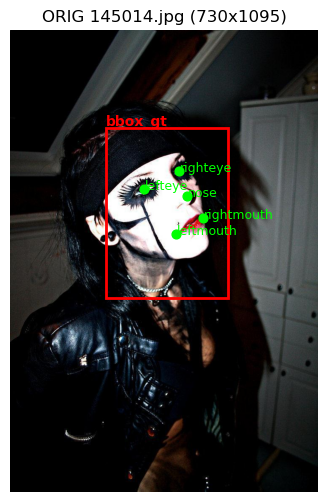

In [54]:
row0 = df_full.iloc[0]
img_path0 = Path(row0["path"])

img0 = Image.open(img_path0).convert("RGB")

plot_landmarks_and_bbox_on_image(
    img0,
    row0,
    title=f"ORIG {row0['image_id']} ({img0.size[0]}x{img0.size[1]})",
)


Отрежем по bbox

In [56]:
POINTS = ["lefteye", "righteye", "nose", "leftmouth", "rightmouth"]


def prepare_cropped_dataset_with_landmarks(
    df: pd.DataFrame,
    out_dir: str | Path,
    *,
    path_col: str = "path",
    image_id_col: str = "image_id",
    bbox_cols: Tuple[str, str, str, str] = ("bbox_x_gt", "bbox_y_gt", "bbox_w_gt", "bbox_h_gt"),
    points: List[str] = POINTS,
    padding: float = 0.30,               # базовый padding для квадрата (0.2..0.5)
    make_square: bool = True,
    out_size: Optional[Tuple[int, int]] = (256, 256),  # (W, H) для PIL.resize; None -> не ресайзить
    save_format: str = "jpg",
    jpeg_quality: int = 95,
    skip_if_exists: bool = True,
    keep_original_cols: bool = True,
    enforce_landmarks_inside: bool = True,  # (2) строгая проверка + (3) стабилизация
    lm_margin: float = 0.08,                # (3) запас вокруг landmarks (доля от стороны bbox)
    max_expand_iters: int = 3,              # (3) сколько раз пробовать расширять bbox, если не влезли
    verbose: bool = True,
) -> pd.DataFrame:
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    xcol, ycol, wcol, hcol = bbox_cols

    # --- validate columns ---
    need = {image_id_col, path_col, xcol, ycol, wcol, hcol}
    for p in points:
        need.add(f"{p}_x")
        need.add(f"{p}_y")
    missing = sorted([c for c in need if c not in df.columns])
    if missing:
        raise ValueError(f"Missing columns in df: {missing}")

    def _clip_xyxy(x1: int, y1: int, x2: int, y2: int, W: int, H: int) -> Tuple[int, int, int, int]:
        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(W, x2); y2 = min(H, y2)
        return x1, y1, x2, y2

    def _xywh_to_center(x: float, y: float, w: float, h: float) -> Tuple[float, float]:
        return x + w / 2.0, y + h / 2.0

    def _propose_bbox_xyxy(
        cx: float, cy: float, w: float, h: float, pad: float, square: bool
    ) -> Tuple[int, int, int, int]:
        if square:
            side = max(w, h) * (1.0 + pad)
            half = side / 2.0
            x1 = int(np.floor(cx - half))
            y1 = int(np.floor(cy - half))
            x2 = int(np.ceil(cx + half))
            y2 = int(np.ceil(cy + half))
        else:
            w2 = w * (1.0 + pad)
            h2 = h * (1.0 + pad)
            x1 = int(np.floor(cx - w2 / 2.0))
            y1 = int(np.floor(cy - h2 / 2.0))
            x2 = int(np.ceil(cx + w2 / 2.0))
            y2 = int(np.ceil(cy + h2 / 2.0))
        return x1, y1, x2, y2

    def _landmarks_bounds_original(row) -> Tuple[float, float, float, float]:
        xs = [float(row[f"{p}_x"]) for p in points]
        ys = [float(row[f"{p}_y"]) for p in points]
        return min(xs), min(ys), max(xs), max(ys)

    def _ensure_bbox_covers_landmarks(
        x1: int, y1: int, x2: int, y2: int,
        row, W: int, H: int,
        cx: float, cy: float,
    ) -> Tuple[int, int, int, int]:
        """
        (3) Стабилизация: если bbox не покрывает landmarks (с margin) — расширяем.
        Делаем это в оригинальных координатах ДО пересчёта.
        """
        if not enforce_landmarks_inside:
            return x1, y1, x2, y2

        lx1, ly1, lx2, ly2 = _landmarks_bounds_original(row)

        # margin — доля от текущей стороны/размера
        cur_w = max(1, x2 - x1)
        cur_h = max(1, y2 - y1)
        m = lm_margin * max(cur_w, cur_h)

        need_x1 = int(np.floor(lx1 - m))
        need_y1 = int(np.floor(ly1 - m))
        need_x2 = int(np.ceil(lx2 + m))
        need_y2 = int(np.ceil(ly2 + m))

        # если всё уже внутри — ок
        if need_x1 >= x1 and need_y1 >= y1 and need_x2 <= x2 and need_y2 <= y2:
            return x1, y1, x2, y2

        # иначе расширяем bbox, сохраняя центр (cx, cy)
        # берём новую сторону/размер как максимум из текущего и требуемого
        req_w = need_x2 - need_x1
        req_h = need_y2 - need_y1

        if make_square:
            side = max(cur_w, cur_h, req_w, req_h)
            half = side / 2.0
            nx1 = int(np.floor(cx - half))
            ny1 = int(np.floor(cy - half))
            nx2 = int(np.ceil(cx + half))
            ny2 = int(np.ceil(cy + half))
        else:
            w2 = max(cur_w, req_w)
            h2 = max(cur_h, req_h)
            nx1 = int(np.floor(cx - w2 / 2.0))
            ny1 = int(np.floor(cy - h2 / 2.0))
            nx2 = int(np.ceil(cx + w2 / 2.0))
            ny2 = int(np.ceil(cy + h2 / 2.0))

        return _clip_xyxy(nx1, ny1, nx2, ny2, W=W, H=H)

    rows_out: List[Dict] = []
    iterator = tqdm(df.iterrows(), total=len(df), ascii=True, desc="Crop+LM") if verbose else df.iterrows()

    for _, row in iterator:
        image_id = str(row[image_id_col])
        in_path = Path(row[path_col])

        out_path = out_dir / f"{Path(image_id).stem}.{save_format.lower()}"
        base: Dict = row.to_dict() if keep_original_cols else {image_id_col: image_id}

        if not in_path.exists():
            base.update({"cropped_path": None, "error": f"missing_file: {in_path}"})
            rows_out.append(base)
            continue

        if skip_if_exists and out_path.exists():
            base.update({"cropped_path": str(out_path)})
            rows_out.append(base)
            continue

        img = Image.open(in_path).convert("RGB")
        W, H = img.size

        # --- GT bbox ---
        x = float(row[xcol]); y = float(row[ycol]); w = float(row[wcol]); h = float(row[hcol])
        cx, cy = _xywh_to_center(x, y, w, h)

        # (1) propose bbox from GT bbox + padding + square
        x1, y1, x2, y2 = _propose_bbox_xyxy(cx, cy, w, h, pad=padding, square=make_square)
        x1, y1, x2, y2 = _clip_xyxy(x1, y1, x2, y2, W=W, H=H)

        if x2 <= x1 or y2 <= y1:
            base.update({"cropped_path": None, "error": "bad_bbox_after_clip"})
            rows_out.append(base)
            continue

        # (3) ensure landmarks inside (may expand bbox)
        for _iter in range(max_expand_iters):
            nx1, ny1, nx2, ny2 = _ensure_bbox_covers_landmarks(x1, y1, x2, y2, row, W, H, cx, cy)
            if (nx1, ny1, nx2, ny2) == (x1, y1, x2, y2):
                break
            x1, y1, x2, y2 = nx1, ny1, nx2, ny2

        crop_w = x2 - x1
        crop_h = y2 - y1
        if crop_w <= 0 or crop_h <= 0:
            base.update({"cropped_path": None, "error": "bad_crop_dims"})
            rows_out.append(base)
            continue

        # (1) crop image using EXACT same x1,y1,x2,y2
        crop = img.crop((x1, y1, x2, y2))

        # (1) landmarks: original -> crop coords (same origin)
        lm = {}
        for p in points:
            lm[f"{p}_x"] = float(row[f"{p}_x"]) - x1
            lm[f"{p}_y"] = float(row[f"{p}_y"]) - y1

        # (2) sanity: landmarks should lie within crop BEFORE resize (allow tiny epsilon)
        if enforce_landmarks_inside:
            eps = 1e-3
            for p in points:
                if not (-eps <= lm[f"{p}_x"] <= crop_w - 1 + eps and -eps <= lm[f"{p}_y"] <= crop_h - 1 + eps):
                    base.update({"cropped_path": None, "error": f"lm_outside_crop_before_resize:{p}"})
                    rows_out.append(base)
                    crop = None
                    break
            if crop is None:
                continue

        # resize (optional) + scale landmarks
        if out_size is not None:
            out_w, out_h = int(out_size[0]), int(out_size[1])
            sx = out_w / float(crop_w)
            sy = out_h / float(crop_h)

            crop = crop.resize((out_w, out_h), resample=Image.BILINEAR)
            for p in points:
                lm[f"{p}_x"] *= sx
                lm[f"{p}_y"] *= sy

            final_W, final_H = out_w, out_h
        else:
            final_W, final_H = crop.size

        # clip landmarks to final image bounds (safety)
        for p in points:
            lm[f"{p}_x"] = float(np.clip(lm[f"{p}_x"], 0.0, final_W - 1.0))
            lm[f"{p}_y"] = float(np.clip(lm[f"{p}_y"], 0.0, final_H - 1.0))

        # (2) final assert: all landmarks inside
        if enforce_landmarks_inside:
            for p in points:
                assert 0.0 <= lm[f"{p}_x"] <= final_W - 1.0, f"final lm x out: {p}"
                assert 0.0 <= lm[f"{p}_y"] <= final_H - 1.0, f"final lm y out: {p}"

        # save
        if save_format.lower() in {"jpg", "jpeg"}:
            crop.save(out_path, quality=int(jpeg_quality), subsampling=0, optimize=True)
        else:
            crop.save(out_path)

        # write output row
        base.update(
            {
                "cropped_path": str(out_path),
                "crop_x": int(x1),
                "crop_y": int(y1),
                "crop_w": int(crop_w),
                "crop_h": int(crop_h),
                "cropped_w": int(final_W),
                "cropped_h": int(final_H),
            }
        )
        base.update(lm)
        rows_out.append(base)

    df_out = pd.DataFrame(rows_out)
    if verbose:
        ok = df_out["cropped_path"].notna().sum()
        print(f"Prepared: {ok}/{len(df_out)} -> {out_dir}")
        if "error" in df_out.columns:
            print("Top errors:\n", df_out["error"].value_counts(dropna=True).head(10))

    return df_out


In [58]:
# Массовое вырезание + сохранение в новую папку
out_dir = r"D:\МФТИ\DL\arcface_mainset_cropped_1"

df_cropped = prepare_cropped_dataset_with_landmarks(
    df_full,
    out_dir,
    padding=0.3,              # было 0.30
    make_square=True,
    out_size=(256, 256),
    enforce_landmarks_inside=True,
    lm_margin=0.08,            # было 0.08
    max_expand_iters=3,        # было 3
    skip_if_exists=False,
)




Crop+LM: 100%|##########| 14000/14000 [11:44<00:00, 19.87it/s]


Prepared: 13987/14000 -> D:\МФТИ\DL\arcface_mainset_cropped_1
Top errors:
 error
lm_outside_crop_before_resize:righteye     9
lm_outside_crop_before_resize:leftmouth    4
Name: count, dtype: int64


In [59]:
bad = df_cropped[df_cropped["cropped_path"].isna()].copy()
print(bad[[ "image_id", "error"]].head(20))


         image_id                                    error
2237   074669.jpg  lm_outside_crop_before_resize:leftmouth
4764   125082.jpg  lm_outside_crop_before_resize:leftmouth
5573   062815.jpg   lm_outside_crop_before_resize:righteye
6326   140914.jpg  lm_outside_crop_before_resize:leftmouth
8497   086778.jpg  lm_outside_crop_before_resize:leftmouth
8854   133636.jpg   lm_outside_crop_before_resize:righteye
9378   108076.jpg   lm_outside_crop_before_resize:righteye
9475   005072.jpg   lm_outside_crop_before_resize:righteye
11066  195173.jpg   lm_outside_crop_before_resize:righteye
11299  001643.jpg   lm_outside_crop_before_resize:righteye
11683  050160.jpg   lm_outside_crop_before_resize:righteye
12454  196032.jpg   lm_outside_crop_before_resize:righteye
13687  019969.jpg   lm_outside_crop_before_resize:righteye


Удаляем плохие картинки

In [60]:
df_ok = df_cropped[df_cropped["cropped_path"].notna()].reset_index(drop=True)
print(len(df_ok), "готово к обучению")


13987 готово к обучению


In [61]:
# дальше учимся по кропам:
df_ok["path"] = df_ok["cropped_path"]


In [62]:
print("Всего изображений:", len(df_ok))
print("Успешно вырезано:", df_ok["path"].notna().sum())
print("Проблемных:", df_ok["path"].isna().sum())


Всего изображений: 13987
Успешно вырезано: 13987
Проблемных: 0


Оригинал + bbox + кроп + пересчитанные landmarks на кропе

In [64]:
POINTS = ["lefteye", "righteye", "nose", "leftmouth", "rightmouth"]


def plot_original_with_bbox(img, row, title="Original + GT bbox"):
    plt.imshow(img)

    # bbox GT
    x = float(row["bbox_x_gt"])
    y = float(row["bbox_y_gt"])
    w = float(row["bbox_w_gt"])
    h = float(row["bbox_h_gt"])

    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
    plt.gca().add_patch(rect)
    plt.text(x, max(0, y - 5), "bbox_gt", color="red", fontsize=9)

    # landmarks (оригинальные)
    for p in POINTS:
        lx = float(row[f"{p}_x"])
        ly = float(row[f"{p}_y"])
        plt.scatter(lx, ly, s=25, c="lime")

    plt.title(title)
    plt.axis("off")


def plot_crop_with_landmarks(img, row, title="Crop + recalculated landmarks"):
    plt.imshow(img)

    # landmarks (пересчитанные)
    for p in POINTS:
        lx = float(row[f"{p}_x"])
        ly = float(row[f"{p}_y"])
        W, H = img.size
        xs = [float(row[f"{p}_x"]) for p in POINTS]
        ys = [float(row[f"{p}_y"]) for p in POINTS]
        print("img size:", (W, H), "x range:", (min(xs), max(xs)), "y range:", (min(ys), max(ys)))
        plt.scatter(lx, ly, s=30, c="cyan")
        plt.text(lx + 2, ly + 2, p, fontsize=8, color="cyan")

    plt.title(title)
    plt.axis("off")


In [65]:
def show_3_examples(df_full, df_ok):
    # берём только те строки, где кроп успешно создан
    df_ok = df_cropped[df_cropped["cropped_path"].notna()].reset_index(drop=True)

    indices = random.sample(range(len(df_ok)), 3)

    for idx in indices:
        row_crop = df_ok.iloc[idx]

        # соответствующая строка в df_full
        row_orig = df_full[df_full["image_id"] == row_crop["image_id"]].iloc[0]

        img_orig = Image.open(row_orig["path"]).convert("RGB")
        img_crop = Image.open(row_crop["cropped_path"]).convert("RGB")

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plot_original_with_bbox(
            img_orig,
            row_orig,
            title=f"ORIGINAL {row_orig['image_id']}"
        )

        plt.subplot(1, 2, 2)
        plot_crop_with_landmarks(
            img_crop,
            row_crop,
            title="CROP + recalculated landmarks"
        )

        plt.tight_layout()
        plt.show()


img size: (256, 256) x range: (98.9546165884194, 162.38706311945748) y range: (95.90092879256966, 152.9659442724458)
img size: (256, 256) x range: (98.9546165884194, 162.38706311945748) y range: (95.90092879256966, 152.9659442724458)
img size: (256, 256) x range: (98.9546165884194, 162.38706311945748) y range: (95.90092879256966, 152.9659442724458)
img size: (256, 256) x range: (98.9546165884194, 162.38706311945748) y range: (95.90092879256966, 152.9659442724458)
img size: (256, 256) x range: (98.9546165884194, 162.38706311945748) y range: (95.90092879256966, 152.9659442724458)


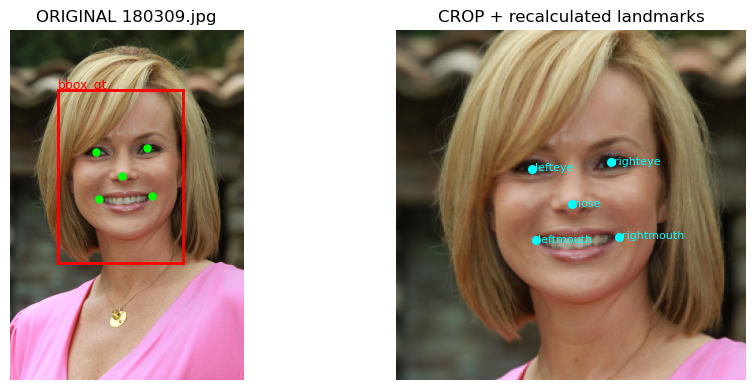

img size: (256, 256) x range: (154.04814004376368, 214.54704595185996) y range: (92.54054054054055, 150.05405405405406)
img size: (256, 256) x range: (154.04814004376368, 214.54704595185996) y range: (92.54054054054055, 150.05405405405406)
img size: (256, 256) x range: (154.04814004376368, 214.54704595185996) y range: (92.54054054054055, 150.05405405405406)
img size: (256, 256) x range: (154.04814004376368, 214.54704595185996) y range: (92.54054054054055, 150.05405405405406)
img size: (256, 256) x range: (154.04814004376368, 214.54704595185996) y range: (92.54054054054055, 150.05405405405406)


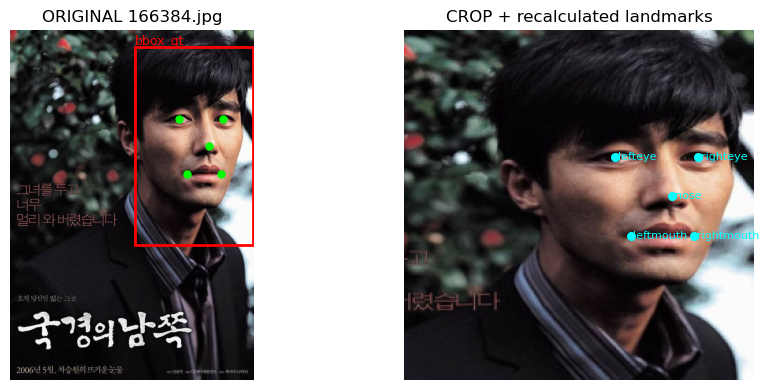

img size: (256, 256) x range: (101.35510204081633, 159.86938775510205) y range: (92.99591836734695, 152.55510204081634)
img size: (256, 256) x range: (101.35510204081633, 159.86938775510205) y range: (92.99591836734695, 152.55510204081634)
img size: (256, 256) x range: (101.35510204081633, 159.86938775510205) y range: (92.99591836734695, 152.55510204081634)
img size: (256, 256) x range: (101.35510204081633, 159.86938775510205) y range: (92.99591836734695, 152.55510204081634)
img size: (256, 256) x range: (101.35510204081633, 159.86938775510205) y range: (92.99591836734695, 152.55510204081634)


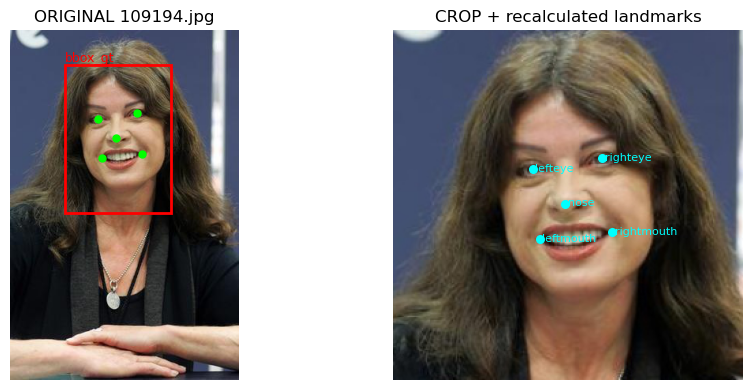

In [66]:
show_3_examples(df_full, df_ok)


Посчитаем, сколько фото на человека

In [68]:
cnt = df_ok["label"].value_counts()
print("людей:", cnt.size)
print("min:", cnt.min(), "median:", int(cnt.median()), "mean:", cnt.mean(), "max:", cnt.max())
print("сколько людей с <=2 фото:", (cnt <= 2).sum())
print("сколько людей с <=3 фото:", (cnt <= 3).sum())


людей: 700
min: 19 median: 20 mean: 19.981428571428573 max: 20
сколько людей с <=2 фото: 0
сколько людей с <=3 фото: 0


## Разделение выборки

In [89]:
df_tmp, df_test = train_test_split(
    df_ok, test_size=0.10, random_state=42, stratify=df_ok["label"]
)
df_train, df_val = train_test_split(
    df_tmp, test_size=0.2, random_state=42, stratify=df_tmp["label"]
)


In [91]:
# проверим все ли люди есть в каждой части
def check_split(df_train, df_val, df_test=None):
    tr = set(df_train["label"].unique())
    va = set(df_val["label"].unique())
    print("missing in train from val:", len(va - tr))
    if df_test is not None:
        te = set(df_test["label"].unique())
        print("missing in train from test:", len(te - tr))

check_split(df_train, df_val, df_test)


missing in train from val: 0
missing in train from test: 0


arcface_mainset/

  splits/
  
    train.csv
    
    val.csv
    
    test.csv

  cropped/
    
    train/
    
      000001.jpg
      
      000002.jpg
      
      ...
    
    val/
    
      ...
    
    test/
    
      ...

  aligned_112/
    
    train/
    
      000001.jpg
      
      ...
    
    val/
    
    test/


In [93]:
# раскидаем по папкам cropped
import shutil

def materialize_split_folders(df, src_col, dst_root, keep_name_col="image_id"):
    dst_root = Path(dst_root)
    dst_root.mkdir(parents=True, exist_ok=True)

    for _, row in df.iterrows():
        src = Path(row[src_col])
        if not src.is_file():
            continue

        # имя файла: можно взять исходное image_id или имя из пути
        if keep_name_col in df.columns:
            fname = str(row[keep_name_col])
        else:
            fname = src.name

        dst = dst_root / fname
        dst.parent.mkdir(parents=True, exist_ok=True)
        if not dst.exists():
            shutil.copy2(src, dst)
            
materialize_split_folders(df_train, "cropped_path", "arcface_mainset_1/cropped/train")
materialize_split_folders(df_val,   "cropped_path", "arcface_mainset_1/cropped/val")
materialize_split_folders(df_test,  "cropped_path", "arcface_mainset_1/cropped/test")


In [94]:
p = Path("arcface_mainset_1/cropped/train")
print("Exists:", p.exists())
print("Files:", len(list(p.glob("*"))) if p.exists() else "N/A")


Exists: True
Files: 10070


In [99]:
p = Path("arcface_mainset_1/cropped/val")
print("Exists:", p.exists())
print("Files:", len(list(p.glob("*"))) if p.exists() else "N/A")


Exists: True
Files: 2518


In [101]:
p = Path("arcface_mainset_1/cropped/test")
print("Exists:", p.exists())
print("Files:", len(list(p.glob("*"))) if p.exists() else "N/A")


Exists: True
Files: 1399


In [95]:
import os
print(os.getcwd())

C:\Users\User


Удалим лишние колонки.

In [117]:
# 1) columns to drop 
celeba_attr_cols = [
    "5_o_Clock_Shadow","Arched_Eyebrows","Attractive","Bags_Under_Eyes","Bald","Bangs","Big_Lips","Big_Nose",
    "Black_Hair","Blond_Hair","Blurry","Brown_Hair","Bushy_Eyebrows","Chubby","Double_Chin","Eyeglasses","Goatee",
    "Gray_Hair","Heavy_Makeup","High_Cheekbones","Male","Mouth_Slightly_Open","Mustache","Narrow_Eyes","No_Beard",
    "Oval_Face","Pale_Skin","Pointy_Nose","Receding_Hairline","Rosy_Cheeks","Sideburns","Smiling","Straight_Hair",
    "Wavy_Hair","Wearing_Earrings","Wearing_Hat","Wearing_Lipstick","Wearing_Necklace","Wearing_Necktie","Young"
]

bbox_cols = ["x_1","y_1","width","height","bbox_x_gt","bbox_y_gt","bbox_w_gt","bbox_h_gt"]

crop_meta_cols = ["crop_x","crop_y","crop_w","crop_h","cropped_w","cropped_h"]

drop_cols = celeba_attr_cols + bbox_cols + crop_meta_cols + ["error"]

# 2) helper: drop only existing cols (safe)
def drop_if_exists(df, cols):
    cols_present = [c for c in cols if c in df.columns]
    return df.drop(columns=cols_present).copy()

# 3) build "thin" dfs (still keep id/label/paths/landmarks)
df_train_thin = drop_if_exists(df_train, drop_cols)
df_val_thin   = drop_if_exists(df_val,   drop_cols)
df_test_thin  = drop_if_exists(df_test,  drop_cols)

print("Before:", df_train.shape, "After:", df_train_thin.shape)
print("Dropped:", [c for c in drop_cols if c in df_train.columns])

# 4)  keep only the columns you actually need
#    for FaceAlignment training on cropped images:
keypoint_cols = [
    "lefteye_x","lefteye_y","righteye_x","righteye_y","nose_x","nose_y",
    "leftmouth_x","leftmouth_y","rightmouth_x","rightmouth_y"
]

keep_cols_alignment = [c for c in (["image_id", "cropped_path"] + keypoint_cols) if c in df_train.columns]
df_train_align = df_train[keep_cols_alignment].copy()
df_val_align   = df_val[keep_cols_alignment].copy()
df_test_align  = df_test[keep_cols_alignment].copy()

# if your Dataset expects column name "path", rename cropped_path -> path
for _df in (df_train_align, df_val_align, df_test_align):
    if "cropped_path" in _df.columns:
        _df.rename(columns={"cropped_path": "path"}, inplace=True)

print("Alignment df:", df_train_align.shape, df_train_align.columns.tolist())

# 5) save to disk 
out_dir = Path("arcface_mainset_1/splits_compact")
out_dir.mkdir(parents=True, exist_ok=True)

df_train_thin.to_csv(out_dir / "train_thin.csv", index=False)
df_val_thin.to_csv(out_dir / "val_thin.csv", index=False)
df_test_thin.to_csv(out_dir / "test_thin.csv", index=False)

df_train_align.to_csv(out_dir / "train_align.csv", index=False)
df_val_align.to_csv(out_dir / "val_align.csv", index=False)
df_test_align.to_csv(out_dir / "test_align.csv", index=False)

print("Saved:", out_dir)


Before: (10070, 69) After: (10070, 14)
Dropped: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'x_1', 'y_1', 'width', 'height', 'bbox_x_gt', 'bbox_y_gt', 'bbox_w_gt', 'bbox_h_gt', 'crop_x', 'crop_y', 'crop_w', 'crop_h', 'cropped_w', 'cropped_h', 'error']
Alignment df: (10070, 12) ['image_id', 'path', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']
Saved: arcface_mainset_1

**Вывод:** В ноутбуке реализован этап кропа по заданным bbox лицевых изображений, обеспечивающий переход от исходных изображений к структурированному датасету лиц. Полученные данные используются как вход для этапа face alignment и дальнейшего обучения моделей распознавания лиц.